Step 1: Importing the necessary Python libraries

- pandas, numpy → data manipulation

- matplotlib, seaborn → visualization

- scikit-learn → preprocessing, model building, evaluation

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Step 2: Load Data

We load the Titanic dataset (train.csv and test.csv).

- train.csv → contains both variables and target (Survived)

- test.csv → contains variables only

In [3]:
#Load Titanic dataset
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Step 3: Exploratory Data Analysis (EDA)

We explore the dataset to understand distributions, missing values, and patterns.

Key checks:

- Missing data

- Target balance (Survived vs Not Survived)

- Feature relationships with survival

In [4]:
#Dataset info
train.info()
train.describe()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Text(0.5, 1.0, 'Survival Distribution')

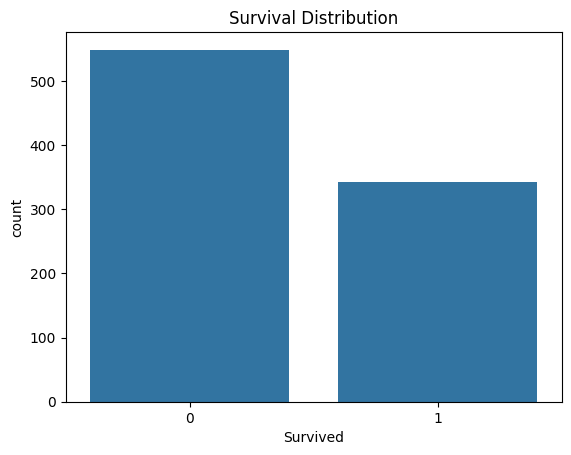

In [5]:
# Target variable distribution
sns.countplot(x="Survived", data=train)
plt.title("Survival Distribution")

Text(0.5, 1.0, 'Survival by Gender')

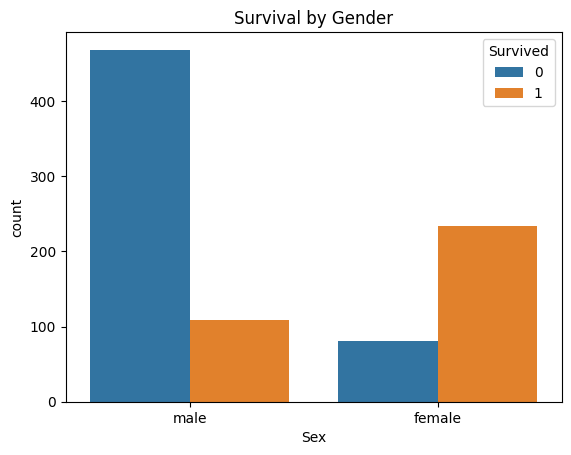

In [6]:
# Survival by Sex
sns.countplot(x="Sex", hue="Survived", data=train)
plt.title("Survival by Gender")

Text(0.5, 1.0, 'Survival by Ticket Class')

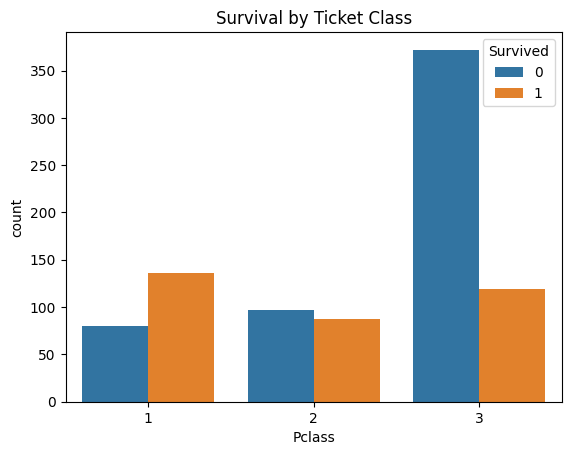

In [7]:
# Survival by Pclass
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.title("Survival by Ticket Class")

Text(0.5, 1.0, 'Age Distribution by Survival')

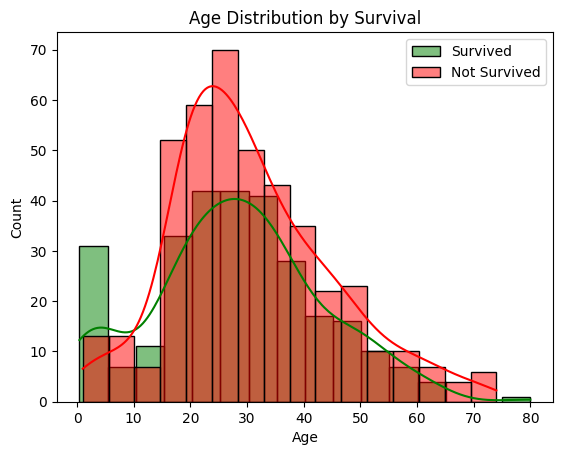

In [8]:
# Age distribution of survivors vs non-survivors
sns.histplot(train[train['Survived']==1]['Age'], kde=True, color="green", label="Survived")
sns.histplot(train[train['Survived']==0]['Age'], kde=True, color="red", label="Not Survived")
plt.legend()
plt.title("Age Distribution by Survival")

Step 4: Data Preprocessing & Feature Engineering

We clean and transform data for modeling:

Feature Engineering: Create new features

- FamilySize = SibSp + Parch + 1

- Extract Title from Name (Mr, Mrs, Miss, etc.)

- Drop irrelevant features: PassengerId, Name, Ticket, Cabin

In [9]:
# Family size
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

# Extract Title from Name
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.")
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.")

# Drop unused columns
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
train = train.drop(columns=drop_cols)
test_data = test.drop(columns=drop_cols)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,0,3,male,22.0,1,0,7.2500,S,2,Mr
1,1,1,female,38.0,1,0,71.2833,C,2,Mrs
2,1,3,female,26.0,0,0,7.9250,S,1,Miss
3,1,1,female,35.0,1,0,53.1000,S,2,Mrs
4,0,3,male,35.0,0,0,8.0500,S,1,Mr


Step 5: Train/Test Split

We separate:

- Features (X) → predictor variables

- Target (y) → Survived

Then split into training and validation sets.

In [10]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Step 6: Preprocessing Pipelines

We use scikit-learn pipelines to handle preprocessing:

- Numeric features → Imputation (median) + Scaling

- Categorical features → Imputation (most frequent) + One-hot encoding

In [11]:
numeric_features = ["Age", "Fare", "FamilySize"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_features = ["Sex", "Embarked", "Pclass", "Title"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])


Step 7: Model Training & Evaluation

We train two baseline models:

- Logistic Regression (linear model)

- Random Forest (tree-based model)

Then compare their accuracy, confusion matrix, and classification report.

In [15]:
# Logistic Regression
log_reg = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model", LogisticRegression(max_iter=1000))])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


Logistic Regression Accuracy: 0.8100558659217877
[[88 17]
 [17 57]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [14]:
# Random Forest
rf_clf = Pipeline(steps=[("preprocessor", preprocessor),
                         ("model", RandomForestClassifier(random_state=42))])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


Random Forest Accuracy: 0.8268156424581006
[[88 17]
 [14 60]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       105
           1       0.78      0.81      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Step 8: Hyperparameter Tuning

We use GridSearchCV to tune Random Forest hyperparameters for better performance.

In [16]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None]
}

grid = GridSearchCV(Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
]), param_grid, cv=5, scoring="accuracy")

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best parameters: {'model__max_depth': 5, 'model__n_estimators': 200}
Best CV score: 0.8342263370432385


Step 9: Final Predictions on Test Data

We use the best tuned model to predict survival on the test dataset, then save results in submission.csv

In [17]:
# Use the best model
final_model = grid.best_estimator_

# Predict on test set
predictions = final_model.predict(test_data)

# Save submission file
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)
print("✅ Submission file created!")


✅ Submission file created!
